In [1]:
%matplotlib notebook
import numpy as np
from scipy.stats import kde
from scipy.ndimage.filters import gaussian_filter
import pandas as pd
import os
import shutil
import subprocess
from subprocess import Popen
import datetime
import matplotlib.pyplot as plt  # plotting
import xlrd

from decimal import Decimal

from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
from scipy.stats import binned_statistic_2d

# make prefix for figure filenames
now = datetime.datetime.now()
date = now.strftime('%Y%m%d')
pref = date

In [2]:
# membrane_path = '../actincme/pkl_files/'

# generally we only want to plot the first membrane object
membrane_object = 1

# set normal_directionality based on whether the normal_vector is pointing such that a similarly oriented filament would have an angle of 0 (1) or 180 (-1)

# membrane_path = '2018August_Tomo27/'
# # if the membrane object to plot is not 1
# membrane_object = 45
# normal_directionality = -1

# membrane_path = '2018_April_Tomo01/'
# normal_directionality = 1

# membrane_path = '2018June_Tomo14_Early_Invagination/'
# normal_directionality = 1

# membrane_path = '2018June_Tomo14_Late_Invagination/'
# normal_directionality = -1

# membrane_path = '2018June_Tomo26/'
# normal_directionality = -1 

# NOTE 2018march does not have unbranched filaments
membrane_path = '2018March/'
normal_directionality = 1

# membrane_path = '2018November_32/'
# normal_directionality = 1

In [3]:
# branched filaments file
branched_filaments_file = []
unbranched_filaments_file = []
membranefilename = []
nogoplane_name = []

files_in_dir = os.listdir(membrane_path)
for file in files_in_dir:
    if 'Branched' in file and 'txt' in file:
        branched_filaments_file = file

for file in files_in_dir:
    if 'Unbranched' in file and 'txt' in file:
        unbranched_filaments_file = file
        
# membrane file

for file in files_in_dir:
    if "embrane" in file or "CoatedVesicle" in file:
        membranefilename = file

# Find unbranched filaments orientation file
for file in files_in_dir:
    if "rientation" in file and 'xls' in file:
        orientation_info_file = file

# find nogo file 
for file in files_in_dir:
    if "eference" in file and "lane.txt" in file:
        nogoplane_name = file
        
membranefilename

'Membrane_2018March_Late_Invagination.txt'

In [149]:
# read in the unbranched filament orientation file
excelfile = pd.read_excel(membrane_path+ orientation_info_file)

# branched filaments
actinfile1 = membrane_path+branched_filaments_file

# unbranched filaments
actinfile2 = membrane_path + unbranched_filaments_file

# nogo plane
nogoplane = membrane_path + nogoplane_name
# membrane
membranefile = membrane_path + membranefilename
excelfile

,Contour Number In Model,Plus-end,Minus-end,Average difference,Unnamed: 4
0,1.0,1.0,5.0,-0.18,NaN
1,3.0,7.0,1.0,-0.18,NaN
2,6.0,9.0,1.0,-0.22,NaN
3,50.0,5.0,1.0,-0.30,NaN
4,51.0,1.0,2.0,0.19,NaN
5,52.0,2.0,1.0,0.27,NaN
6,54.0,1.0,3.0,-0.43,NaN
7,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN


In [150]:
# more manual way of finding the filex

# # working_dir = os.curdir
# actinfile1 = '2018June_Tomo26/UnbranchedActin_2018June_Tomo26_CME_Invagination.txt'
# actinfile2 = '2018June_Tomo26/BranchedActin_2018June_Tomo26_CME_Invagination.txt'
# membranefile = '2018June_Tomo26/Membrane_2018June_Tomo26_CME_Invagination.txt'
# #TODO: add in excel file into the code 
# #excelfile = 'placeholder.txt'
# excelfile = pd.read_excel('2018June_Tomo26/UnbranchedFilamentOrientationInfo.xlsx')
# # c = open(membranefile,'r')
# # c.readlines()
# nogoplane = '2018June_Tomo26/Reference_Plane.txt'

In [151]:
data_xls = excelfile
data_xls

#Purpose: Fix differences between folders
if 'Contour Number In Model' in data_xls.columns:
    data_xls = data_xls.rename(columns = {'Contour Number In Model': 'Contour number in model'})

#Purpose: Read unbranched coords txt file into a dataframe which is returned.
def read_text_unbranched_coords(file, label = 'fil'):
    import pandas as pd
    ub_coordsfile =  open(file, 'r')
    coords = pd.read_table(ub_coordsfile, delim_whitespace=True)
    coords.columns = ['Contour number in model', 'X', 'Y', 'Z']
    return coords
# actinfile2 is unbranched filaments
ub_coords = read_text_unbranched_coords(actinfile2)


#Purpose: Merge unbranched coords txt file with dataframe from excel file
def merge_files(unbranched_coords, xls_to_df):
    data_xls = xls_to_df
    merged_ub_coords = data_xls.merge(unbranched_coords)
    merged_ub_coords['X_nm'], merged_ub_coords['Y_nm'], merged_ub_coords['Z_nm'] = 0.06*merged_ub_coords['X'], 0.06*merged_ub_coords['Y'], 0.06*merged_ub_coords['Z']
#   merged_ub_coords = merged_ub_coords[['Contour number in model','X','Y','Z','X_nm','Y_nm','Z_nm','Plus end point','Minus end point','Clear Result (0-1)', \
#               'Filament length (nm)','Comment']]
    return merged_ub_coords
ub_coords
print(ub_coords.columns)
print(data_xls.columns)
merged_df = merge_files(ub_coords, data_xls)
merged_df

#Purpose: Add tag to the merged df
plus_ends = {}
for index, row in merged_df.iterrows():
    if(row['Minus-end'] == 1):
        #print('ya')
        plus_ends[row['Contour number in model']] = 'last'
    else:
        plus_ends[row['Contour number in model']] = 'first'
list_of_ends = []
for index, row in merged_df.iterrows():
    if(plus_ends[row['Contour number in model']] == 'last'):
        list_of_ends += ['first']
    else:
        list_of_ends += ['last']
merged_df['minus end point'] = list_of_ends
merged_df.head(50)
merged_df= merged_df.rename(columns = {'Contour number in model':'contour'})
merged_df

#Purpose: Select certain columns from merged table only
selected = merged_df[['contour', 'X', 'Y', 'Z', 'minus end point']]
selected= selected.rename(columns = {'contour':'fil'})
selected_ub_coords = selected.set_index('fil')
selected_ub_coords

Index(['Contour number in model', 'X', 'Y', 'Z'], dtype='object')
Index(['Contour number in model', 'Plus-end', 'Minus-end',
       'Average difference', 'Unnamed: 4'],
      dtype='object')


,X,Y,Z,minus end point
fil,,,,
1.0,1331,844,183,last
1.0,1339,925,166,last
1.0,1345,984,154,last
1.0,1349,1013,149,last
3.0,1687,1426,178,first
3.0,1693,1388,177,first
3.0,1701,1344,176,first
3.0,1702,1300,174,first
3.0,1700,1263,172,first


In [6]:
#  read in text file
# for all txt filex

# for a particular txt file


def read_text(file, label='fil'):
    
    import pandas as pd
    coordinatesfile = open(file, 'r')
    
    coords_df = pd.read_table(coordinatesfile, delim_whitespace=True)
#     check if there is an 'object' and 'contour' column (membrane)
    if len(coords_df.columns)==4:
        coords_df.columns=[label, 'X', 'Y', 'Z']
        coords_df=coords_df.set_index([label])
    
    elif len(coords_df.columns)==5:
        coords_df.columns=['object', label, 'X', 'Y', 'Z']
        coords_df=coords_df.set_index(['object', label])
        
    else:
        print("unexpected number of columns!")
#     make multiindex
    coordinatesfile.close()
    return coords_df

actin1 = read_text(actinfile1)
actin2 = read_text(actinfile2)
membrane = read_text(membranefile, 'contour')
# membrane
branched_coords = actin1


In [7]:
#No-Go Plane Definition 
#Taken from here: https://stackoverflow.com/questions/53698635/how-to-define-a-plane-with-3-points-and-plot-it-in-3d
ngplane = read_text(nogoplane)
#ngplane.reset_index()
xvals = ngplane['X'].values
yvals = ngplane['Y'].values
zvals = ngplane['Z'].values
xs = []
ys = []
zs = []


# for i in range(int(xvals.size/2)):
#     a = i+1

# define a plane using any three points from the nogo text file

# e.g. use points 0, 1, and last (-1)

i = 0
j = 1
k =-1

points = [[xvals[i], yvals[i], zvals[i]],
          [xvals[j], yvals[j], zvals[j]], 
          [xvals[k], yvals[k], zvals[k]]]

p0, p1, p2 = points
x0, y0, z0 = p0
x1, y1, z1 = p1
x2, y2, z2 = p2

# calculate vectors between points 0 and 1 (and between 1 and 2)

ux, uy, uz = u = [x1-x0, y1-y0, z1-z0]
vx, vy, vz = v = [x2-x0, y2-y0, z2-z0]

# calcualte cross product

u_cross_v = [uy*vz-uz*vy, uz*vx-ux*vz, ux*vy-uy*vx]

# normal vector as an array

point  = np.array(p0)
normal = np.array(u_cross_v)

d = -point.dot(normal)
xx, yy = np.meshgrid(range(10), range(10))

z = (-normal[0] * xx - normal[1] * yy - d) * 1. / normal[2]
# print(z)

# xs.append(xx)
# ys.append(yy)
# zs.append(z)


# define which mebmrane surface to plot
## object == 1 is the CCP


In [8]:
all_membranes = membrane.reset_index()
CCP = all_membranes[all_membranes['object']==membrane_object]


<IPython.core.display.Javascript object>


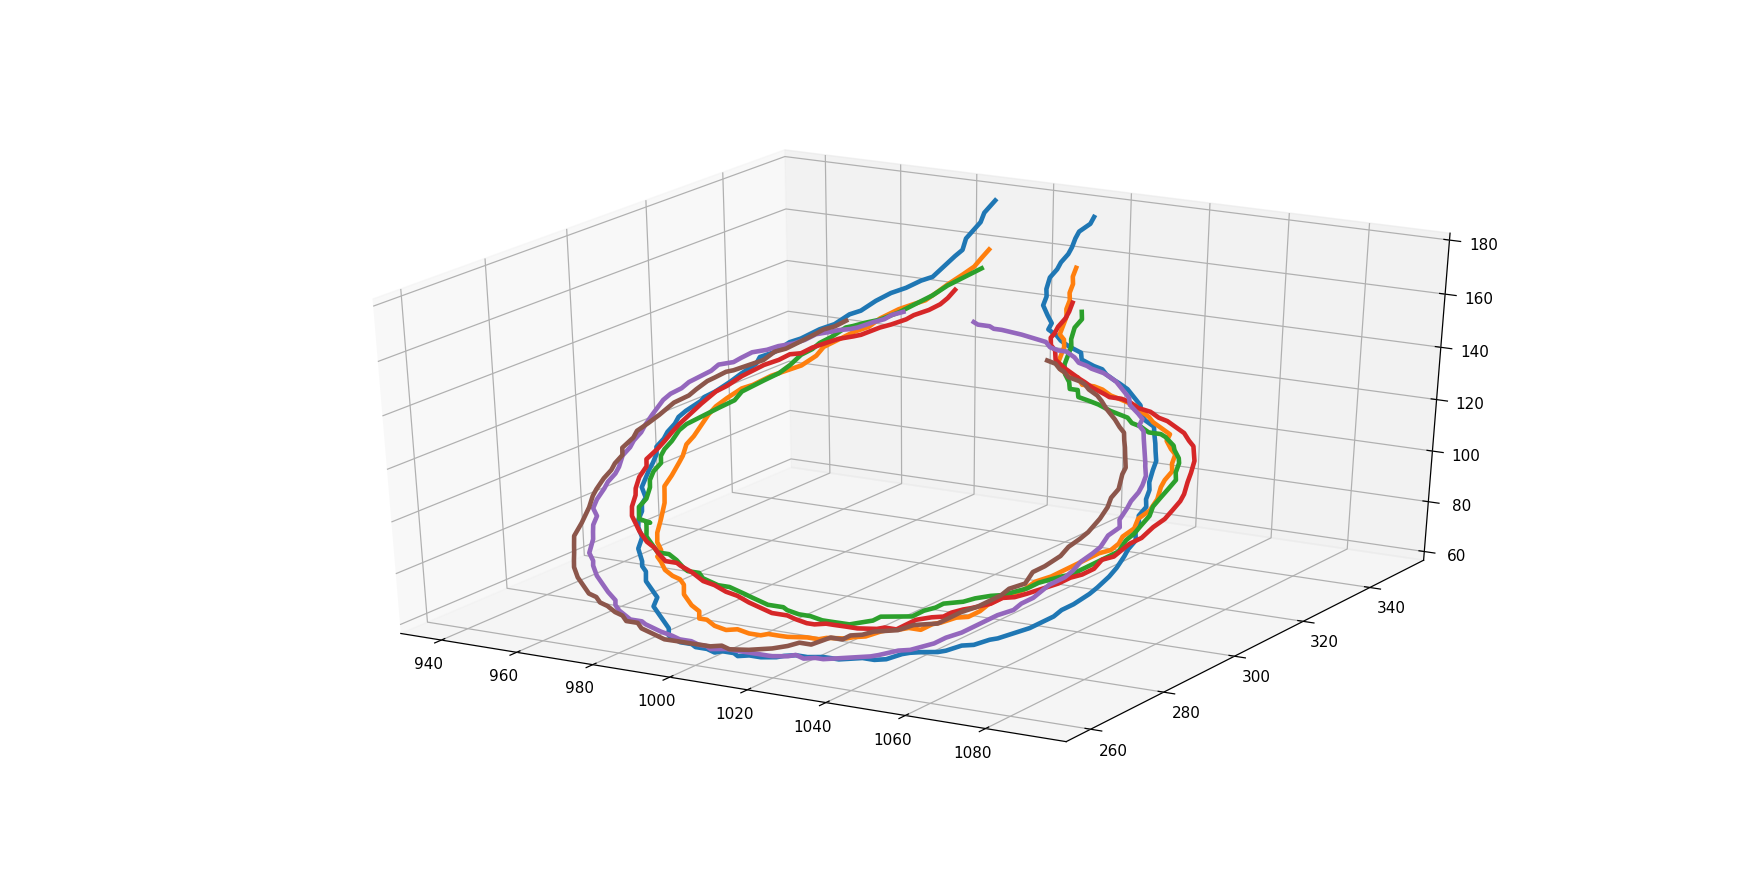

/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/c

In [9]:
# plot membrane

# %matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=[16,8])
ax=fig.add_subplot(111, projection='3d')

for contourr in CCP['contour'].unique():
    cur_contour = CCP[CCP['contour']==contourr]
    ax.plot(xs=cur_contour['X'], ys=cur_contour['Y'], zs=cur_contour['Z'], linewidth=3)

<IPython.core.display.Javascript object>


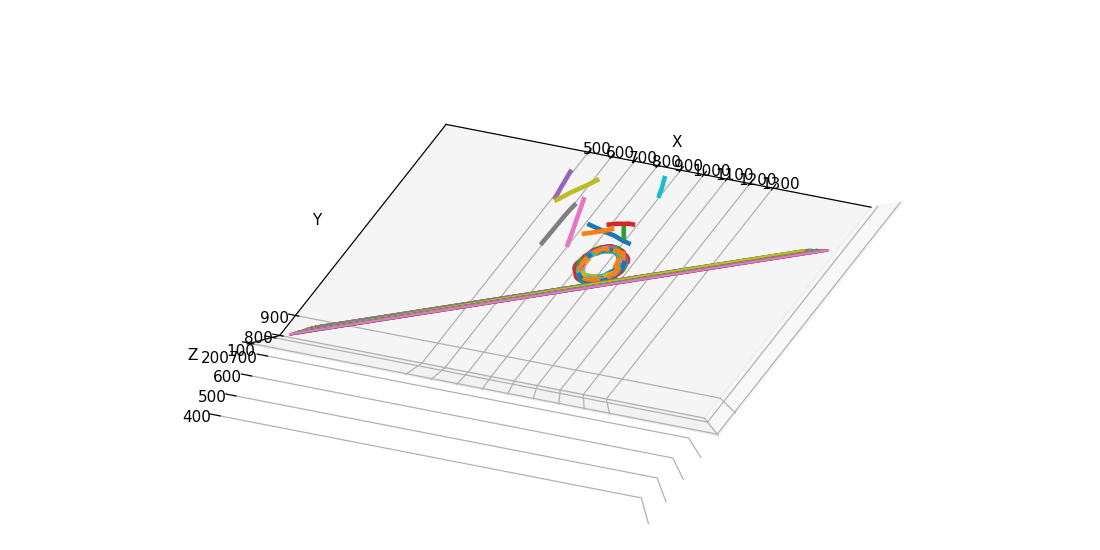

/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/c

Text(0.5, 0, 'Z')

In [37]:
# plot actin and membrane
# %matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=[10,5])
ax=fig.add_subplot(111, projection='3d')

# all_membranes = membrane.reset_index()
# CCP = all_membranes[all_membranes['object']==1]

for filament in selected_ub_coords.index.unique():
    cur_filament = selected_ub_coords[selected_ub_coords.index==filament]
    ax.plot(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], linewidth=3,)

for filament in branched_coords.index.unique():
    cur_filament = coords[coords.index==filament]
    ax.plot(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], linewidth=3)

for contourr in CCP['contour'].unique():
    cur_contour = CCP[CCP['contour']==contourr]
    ax.plot(xs=cur_contour['X'], ys=cur_contour['Y'], zs=cur_contour['Z'], linewidth=3,  linestyle = 'dashed')

for i in range(int(xvals.size/2)):
    ax.plot([xvals[i], xvals[i+1]],[yvals[i], yvals[i+1]], zs = [zvals[i], zvals[i+1]])
 


# plot membrane
# pit = membranes[membranes['contour']==1]
# ax.plot(xs = pit['X'], ys=pit['Y'], zs = pit['Z'], linewidth=5)
# ax.autoscale(enable=True,tight=True) 

# plt.xlim([500,1400])
# plt.ylim([350,950])
# ax.set_zlim([50,250])

ax.set_xticks(np.arange(500,1400,100))
ax.set_yticks(np.arange(400,1000,100))
ax.set_zticks([100,200])


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

In [156]:
#Distance between reference lines & filaments
selected_ub_coords
for index, row in selected_ub_coords.iterrows():
    #line spans p to q and 'r' is the given point
    p = np.array([xvals[0], yvals[0], zvals[0]])
    q = np.array([xvals[1], yvals[1], zvals[1]])
    r = np.array([row.X, row.Y, row.Z])

    def t(p, q, r):
        x = p-q
        return np.dot(r-q, x)/np.dot(x, x)

    def d(p, q, r):
        return np.linalg.norm(t(p, q, r)*(p-q)+q-r)

    print(d(p, q, r))
    

279.6523118601727
312.0892217750202
336.2798244760153
347.4071438127158
262.03510295787464
237.82447822586727
208.89952588769424
185.9434535680502
169.06745570161291
141.94214100216593
139.1561322020299
382.1297742081514
357.7734178391426
328.5399472803484
292.52679438836765
245.9994881764933
201.49387091129975
141.49656709475056
118.35333491012102
102.66594679999706
259.7915468226614
234.53581397392944
218.137936252986
199.45150062328088
165.51646133608284
158.13814729158938
231.29905533624753
232.9419909165822
169.74414368945253
311.45450108381635
262.5173554094131
226.0982072954025


<IPython.core.display.Javascript object>


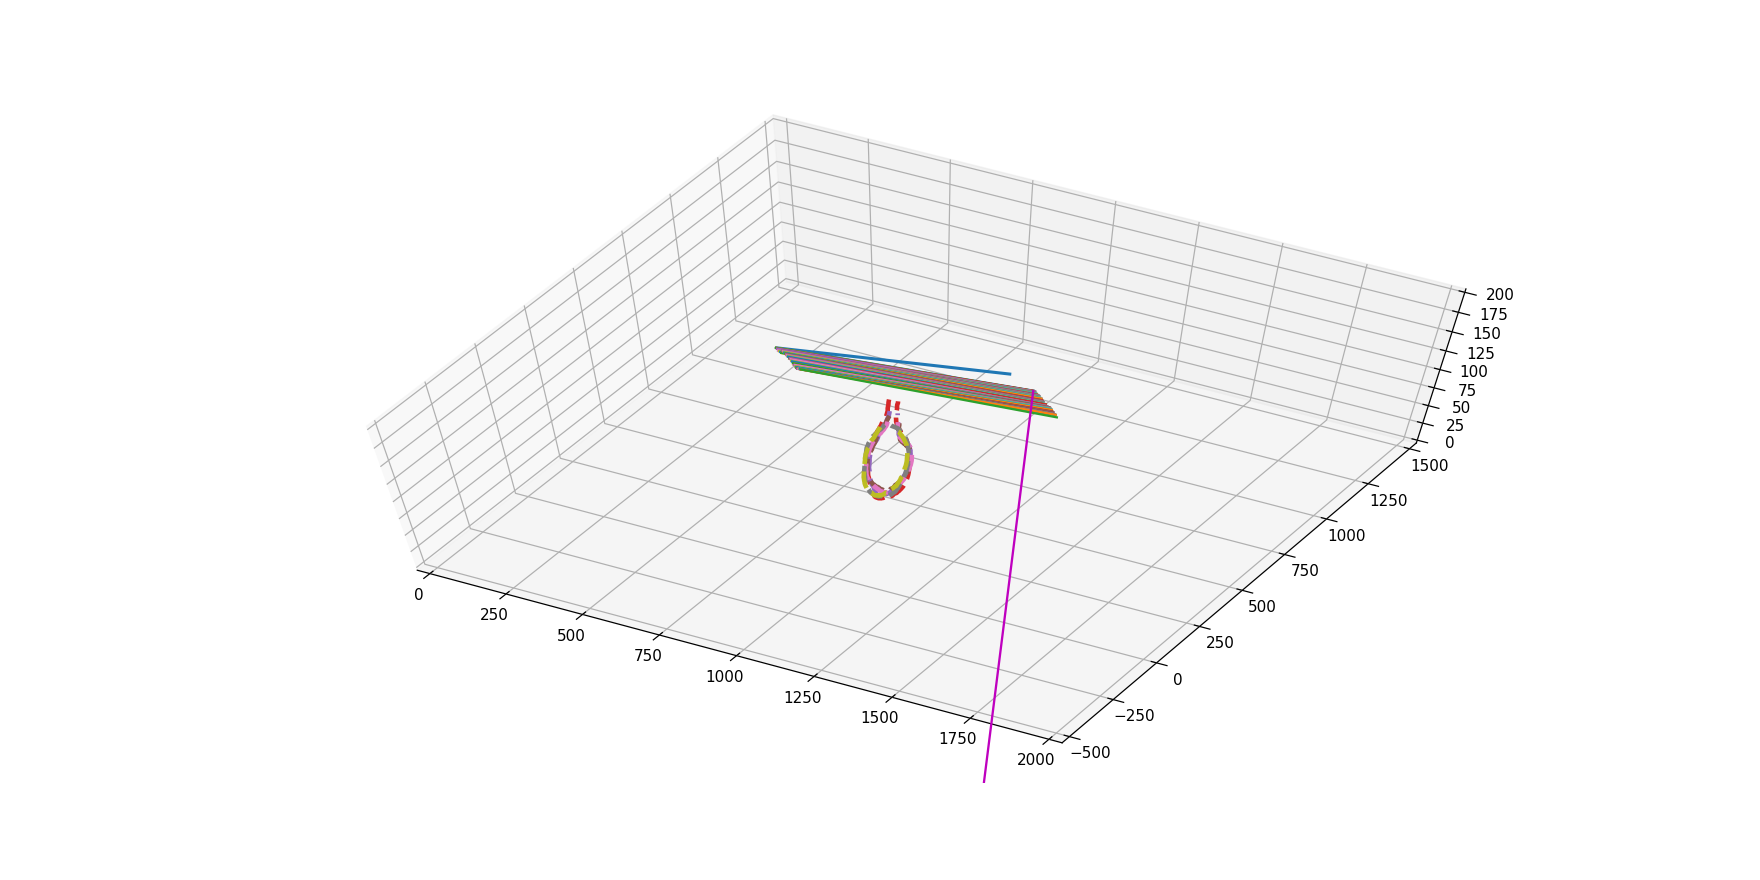

/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/c

In [10]:
# plot the nogo lines, membrane contour, and the plane defined by three lines from the nogo file

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=[16,8])
ax = fig.add_subplot(111, projection='3d')

ax.plot(xs=[xvals[0], xvals[1], xvals[-1]],ys =[yvals[0], yvals[1], yvals[-1]], zs = [zvals[0], zvals[1], zvals[-1]],linewidth=2)
for i in range(int(xvals.size/2)):
    ax.plot(xs=[xvals[i], xvals[i+1]],ys =[yvals[i], yvals[i+1]], zs = [zvals[i], zvals[i+1]])

for contourr in CCP['contour'].unique():
    cur_contour = CCP[CCP['contour']==contourr]
    ax.plot(xs=cur_contour['X'], ys=cur_contour['Y'], zs=cur_contour['Z'], linewidth=3,  linestyle = 'dashed')
    
ax.plot(xs = [x0, normal[0]], ys = [y0, normal[1]], zs = [z0, normal[2]], color="m")

plt.xlim([0,2000])
plt.ylim([-500,1500])
ax.set_zlim([0, 200])

plt.show()

    

# calculate directionality of filaments
## branched filaments here

In [11]:
ydirs=[]
zdirs=[]
all_filaments = []
filament_lengths = []

dot_products = []
relative_angles = []
normal_angles = []
relative_angles_90 = []
normal_vector = normal


for filament in branched_coords.index.unique():
    cur_filament = branched_coords[branched_coords.index==filament]
    xx = cur_filament.X
    yy = cur_filament.Y
    zz = cur_filament.Z

    deltaxx = sum(np.diff(xx))
    deltayy = sum(np.diff(yy))
    deltazz = sum(np.diff(zz))
    
    fil_vector = (deltaxx, deltayy, deltazz)
    
#     np.dot(zz.iloc[-1],zz.iloc[0])
    fil_length = np.sqrt(deltaxx*deltaxx+deltayy*deltayy+deltazz+deltazz)

#     calculate the dot product with respect to the normal vector
#     normal_orientation_dp = np.dot(fil_vector, normal)

    # make sure they are unit vectors first
    
    unit_vector_1 = normal_vector / np.linalg.norm(normal_vector)
    unit_vector_2 = fil_vector / np.linalg.norm(fil_vector)
    
#     calculate the dot product bewtween these two vectors.
# NOTE that the sign may have to be manually determined in different datasets. 
# We don't know ahead of time whether the normal vector is pointing "up" or "down."
# so when plotting, we will check whether the value seems to be flipped or not. 
# We set the normal_directionality value (1 or -1) near the top of the notebook when setting the folder name
    
    dot_product = np.dot(unit_vector_1, unit_vector_2)*normal_directionality
    
#     relative_angle is the relative angle between the normal vector and the filament vector
#   starts at 0 and ends at 180

    relative_angle = np.degrees((np.pi)-np.arccos(dot_product)) 
    
#     relative_angle_90 starts at +90 and ends at -90 degrees
    relative_angle_90 = -np.degrees((np.arccos(dot_product)-(np.pi)/2)) 
   
#     we're not usig this value currently
    normal_angle = np.degrees(np.arccos(np.clip(dot_product, -1.0, 1.0)))

    
    dot_products.append(dot_product)
    
    relative_angles.append(relative_angle)
#     normal_angles.append(normal_angle)


# calculate orientation relative to the y axis plane (ydir) or z axis plane (zdir)
#     define direction theta such that 1 is up , 0 is parallel and -1 is down.
# arcsin(z/L)
#   take inverse so that + faces membrane (which is toward zero I think)
#     ydir = (deltayy/fil_length)
    ydir = np.degrees(np.arcsin(deltayy/fil_length))
   
    ydirs.append(ydir)
    
    zdir = np.degrees(-(np.arcsin(deltazz/fil_length)))
#     zdir = -np.arcsin(deltazz/fil_length)

    zdirs.append(zdir)
    
    filament_lengths.append(fil_length)
    
    cur_filament['ydir']=ydir
    cur_filament['zdir']=zdir
    cur_filament['length']=fil_length
    cur_filament['relative_angle'] = relative_angle
    cur_filament['relative_angle_90'] = relative_angle_90
    cur_filament['dot_product'] = dot_product
    all_filaments.append(cur_filament)
    
all_filaments_df = pd.concat(all_filaments)
all_filaments_df

/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

,X,Y,Z,ydir,zdir,length,relative_angle,relative_angle_90,dot_product
fil,,,,,,,,,
1,762,309,53,23.829111,12.970542,44.553339,87.967338,-2.032662,-0.035469
1,721,327,43,23.829111,12.970542,44.553339,87.967338,-2.032662,-0.035469
2,833,302,60,-27.459247,4.407695,117.106789,78.650590,-11.349410,-0.196792
2,780,276,57,-27.459247,4.407695,117.106789,78.650590,-11.349410,-0.196792
2,729,248,51,-27.459247,4.407695,117.106789,78.650590,-11.349410,-0.196792
3,914,317,37,5.697344,-10.727489,80.585358,104.044130,14.044130,0.242669
3,877,318,42,5.697344,-10.727489,80.585358,104.044130,14.044130,0.242669
3,850,323,44,5.697344,-10.727489,80.585358,104.044130,14.044130,0.242669
3,834,325,52,5.697344,-10.727489,80.585358,104.044130,14.044130,0.242669


<IPython.core.display.Javascript object>


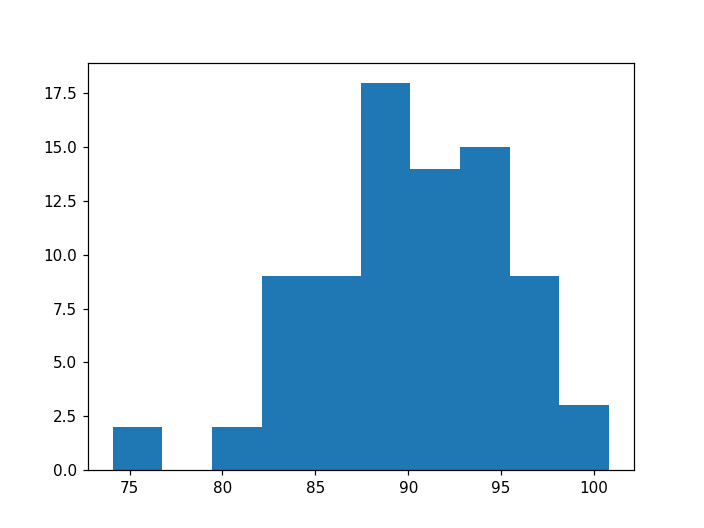

(array([ 2.,  0.,  2.,  9.,  9., 18., 14., 15.,  9.,  3.]),
 array([ 74.0955893 ,  76.76541032,  79.43523134,  82.10505236,
         84.77487338,  87.44469441,  90.11451543,  92.78433645,
         95.45415747,  98.12397849, 100.79379951]),
 <a list of 10 Patch objects>)

In [88]:
# plt.figure()
# plt.hist(relative_angles)
# # plt.show()

In [86]:
# for i in all_filaments_df.index.unique(level='fil'):
#     all_filaments_df['fil']==i

In [12]:
# save
all_filaments_df.to_csv(membrane_path+'branched_filaments_angles.csv')
# could just save the unique filaments and not every model point

<IPython.core.display.Javascript object>


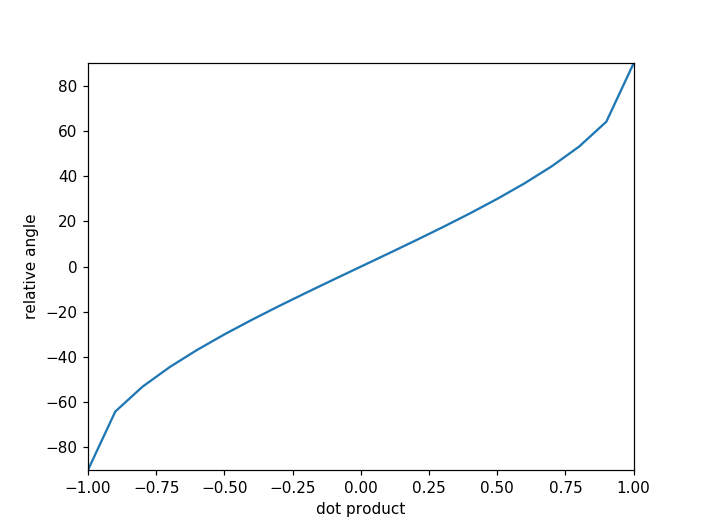

Text(0, 0.5, 'relative angle')

In [49]:
# # just to check the relationship between dot product and angle

# dots = np.arange(-1,1.1,0.1)
# # thetas = 
# thetas = np.degrees((np.pi)-np.arccos(dots)) 
# thetas_90 = -np.degrees((np.arccos(dots)-(np.pi)/2)) 

# fig = plt.figure()
# ax=fig.add_subplot(111)
# ax.plot(dots,thetas_90)
# plt.xlim([-1,1])
# plt.ylim([-90,90])
# plt.xlabel('dot product')
# plt.ylabel('relative angle')


# Directionality of Unbranched Filaments


In [131]:
ydirs=[]
zdirs=[]
all_filaments = []
filament_lengths = []
for filament in selected_ub_coords.index.unique():
    cur_filament = selected_ub_coords[selected_ub_coords.index==filament]
    xx = cur_filament.X
    yy = cur_filament.Y
    zz = cur_filament.Z

    deltaxx = sum(np.diff(xx))
    deltayy = sum(np.diff(yy))
    deltazz = sum(np.diff(zz))

#     np.dot(zz.iloc[-1],zz.iloc[0])
    fil_length = np.sqrt(deltaxx*deltaxx+deltayy*deltayy+deltazz+deltazz)
    
#     calculate the dot product with respect to the normal vector
#     normal_orientation_dp = np.dot(fil_vector, normal)

    # make sure they are unit vectors first
    
    unit_vector_1 = normal_vector / np.linalg.norm(normal_vector)
    unit_vector_2 = fil_vector / np.linalg.norm(fil_vector)
    
#     calculate the dot product bewtween these two vectors.
# NOTE that the sign may have to be manually determined in different datasets. 
# We don't know ahead of time whether the normal vector is pointing "up" or "down."
# so when plotting, we will check whether the value seems to be flipped or not. 
# We set the normal_directionality value (1 or -1) near the top of the notebook when setting the folder name
    
    dot_product = np.dot(unit_vector_1, unit_vector_2)*normal_directionality
    
  
#  ******   if orientaton of ub filament is plus_end_first, then make dot_product the opposite sign HERE ****
  
    
#     relative_angle is the relative angle between the normal vector and the filament vector
#   starts at 0 and ends at 180

    relative_angle = np.degrees((np.pi)-np.arccos(dot_product)) 
    
#     relative_angle_90 starts at +90 and ends at -90 degrees
    relative_angle_90 = -np.degrees((np.arccos(dot_product)-(np.pi)/2)) 
    
#     we're not usig this value currently
    normal_angle = np.degrees(np.arccos(np.clip(dot_product, -1.0, 1.0)))

    
    dot_products.append(dot_product)
    
    relative_angles.append(relative_angle)
#     normal_angles.append(normal_angle)


# calculate orientation relative to the y axis plane (ydir) or z axis plane (zdir)
#     define direction theta such that 1 is up , 0 is parallel and -1 is down.
# arcsin(z/L)
#   take inverse so that + faces membrane (which is toward zero I think)
#     ydir = (deltayy/fil_length)
    ydir = np.degrees(np.arcsin(deltayy/fil_length))
   
    ydirs.append(ydir)
    
    zdir = np.degrees(-(np.arcsin(deltazz/fil_length)))
#     zdir = -np.arcsin(deltazz/fil_length)

    zdirs.append(zdir)
    
    filament_lengths.append(fil_length)
    
    cur_filament['ydir']=ydir
    cur_filament['zdir']=zdir
    cur_filament['length']=fil_length
    cur_filament['relative_angle'] = relative_angle
    cur_filament['dot_product'] = dot_product
    all_filaments.append(cur_filament)
    
ub_all_filaments_df = pd.concat(all_filaments)
ub_all_filaments_df

/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

,X,Y,Z,minus end point,ydir,zdir,length,relative_angle,dot_product
fil,,,,,,,,,
1,1757,1015,175,first,-81.766519,-0.409921,419.322072,61.911747,-0.470831
1,1754,987,174,first,-81.766519,-0.409921,419.322072,61.911747,-0.470831
1,1753,974,173,first,-81.766519,-0.409921,419.322072,61.911747,-0.470831
1,1755,950,173,first,-81.766519,-0.409921,419.322072,61.911747,-0.470831
1,1754,937,173,first,-81.766519,-0.409921,419.322072,61.911747,-0.470831
...,...,...,...,...,...,...,...,...,...
511,1204,817,100,first,44.754537,-36.605718,139.190517,61.911747,-0.470831
511,1225,839,118,first,44.754537,-36.605718,139.190517,61.911747,-0.470831
511,1251,865,140,first,44.754537,-36.605718,139.190517,61.911747,-0.470831


In [15]:
# # hsv 75% colormap
# # https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
# # %matplotlib inline
# import matplotlib.colors as colors

# def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
#     new_cmap = colors.LinearSegmentedColormap.from_list(
#         'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
#         cmap(np.linspace(minval, maxval, n)))
#     return new_cmap

# cmap = plt.get_cmap('hsv')
# new_cmap = truncate_colormap(cmap, 0, 0.75)

In [16]:
# choose a colormap

import matplotlib.colors as colors
import matplotlib.cm as cmx

# colorss = cm = plt.get_cmap('bwr') 
# colorss = cm = plt.get_cmap('viridis') 
colorss = cm = plt.get_cmap('coolwarm') 


# colorss = cm = plt.get_cmap(new_cmap)
 
# cNorm  = colors.Normalize(vmin=0, vmax=values[-1])

# cNorm  = colors.Normalize(vmin=-90, vmax=90)

cNorm  = colors.Normalize(vmin=0, vmax=180)

# set colorlim to [-1 to 1]
# cNorm  = colors.Normalize(vmin=-1, vmax=1)

scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=colorss)
print(scalarMap.get_clim())


(0.0, 180.0)


<IPython.core.display.Javascript object>


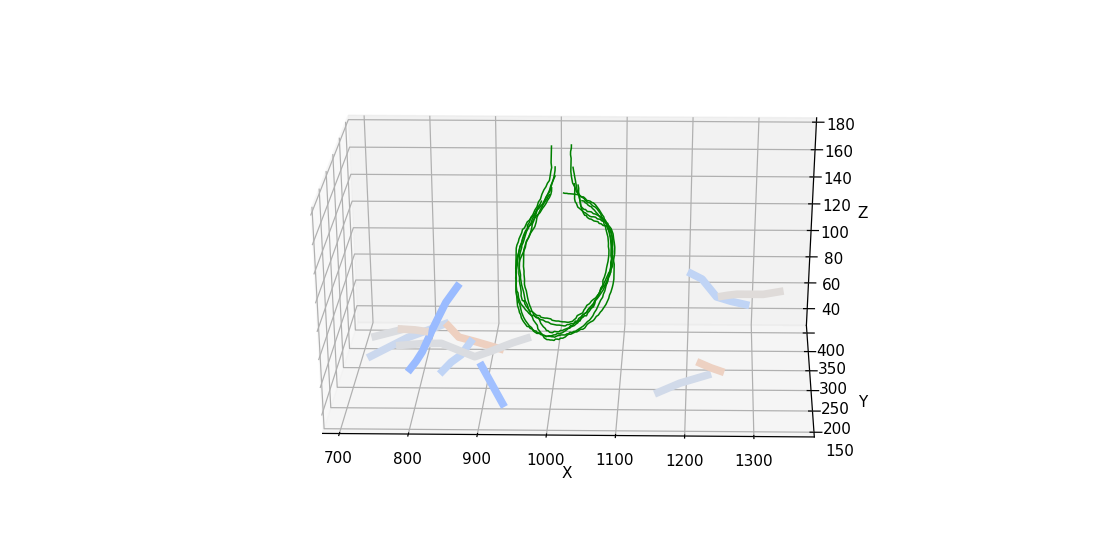

/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/c

Text(0.5, 0, 'Z')

In [17]:
# color code angles
# %matplotlib inline
from matplotlib import cm

# plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=[10,5])
# ax=fig.add_subplot(111, projection='3d')
ax=fig.gca(projection='3d')


# membrane

for contourr in CCP['contour'].unique():
    cur_contour = CCP[CCP['contour']==contourr]
    ax.plot(xs=cur_contour['X'], ys=cur_contour['Y'], zs=cur_contour['Z'], color='g', linewidth=1)

for filament in all_filaments_df.index.unique():
    cur_filament = all_filaments_df[all_filaments_df.index==filament]
#     colorVal = scalarMap.to_rgba(cur_filament['ydir'])
    colorVal = scalarMap.to_rgba(cur_filament['relative_angle'])
#     colorVal = scalarMap.to_rgba(cur_filament['relative_angle_90'])
    
#     colorVal = scalarMap.to_rgba(cur_filament['dot_product'])
    
    ax.plot(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], color=colorVal[0], linewidth=5)
    
# for filament in ub_all_filaments_df.index.unique():
#     cur_filament = ub_all_filaments_df[ub_all_filaments_df.index==filament]
#     colorVal = scalarMap.to_rgba(cur_filament['ydir'])
#     ax.plot(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], color=colorVal[0], linewidth=5)
    
# plt.xlim([500,1400])
# plt.ylim([350,950])
# ax.set_zlim([50,250])

# ax.set_xticks(np.arange(500,1400,100))
# ax.set_yticks(np.arange(400,1000,100))
# ax.set_zticks([100,200])
# cbar = fig.colorbar(colorVal,ax=ax)
# fig.colorbar(p)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# end! the rest is just draft material

In [ ]:
# save CCP membrane coordinates
CCP=CCP.reset_index().set_index(['object','contour'])

CCP.to_pickle('CCP_membrane_coordinates.pkl')
CCP

In [27]:
# import 3D meshing of membrane made by "symmetrecized plotting.ipynb"
import pickle as pkl
cur_mesh = pkl.load(open('rotate_obj.pkl','rb'))
cur_mesh

FileNotFoundError: [Errno 2] No such file or directory: 'rotate_obj.pkl'

<IPython.core.display.Javascript object>


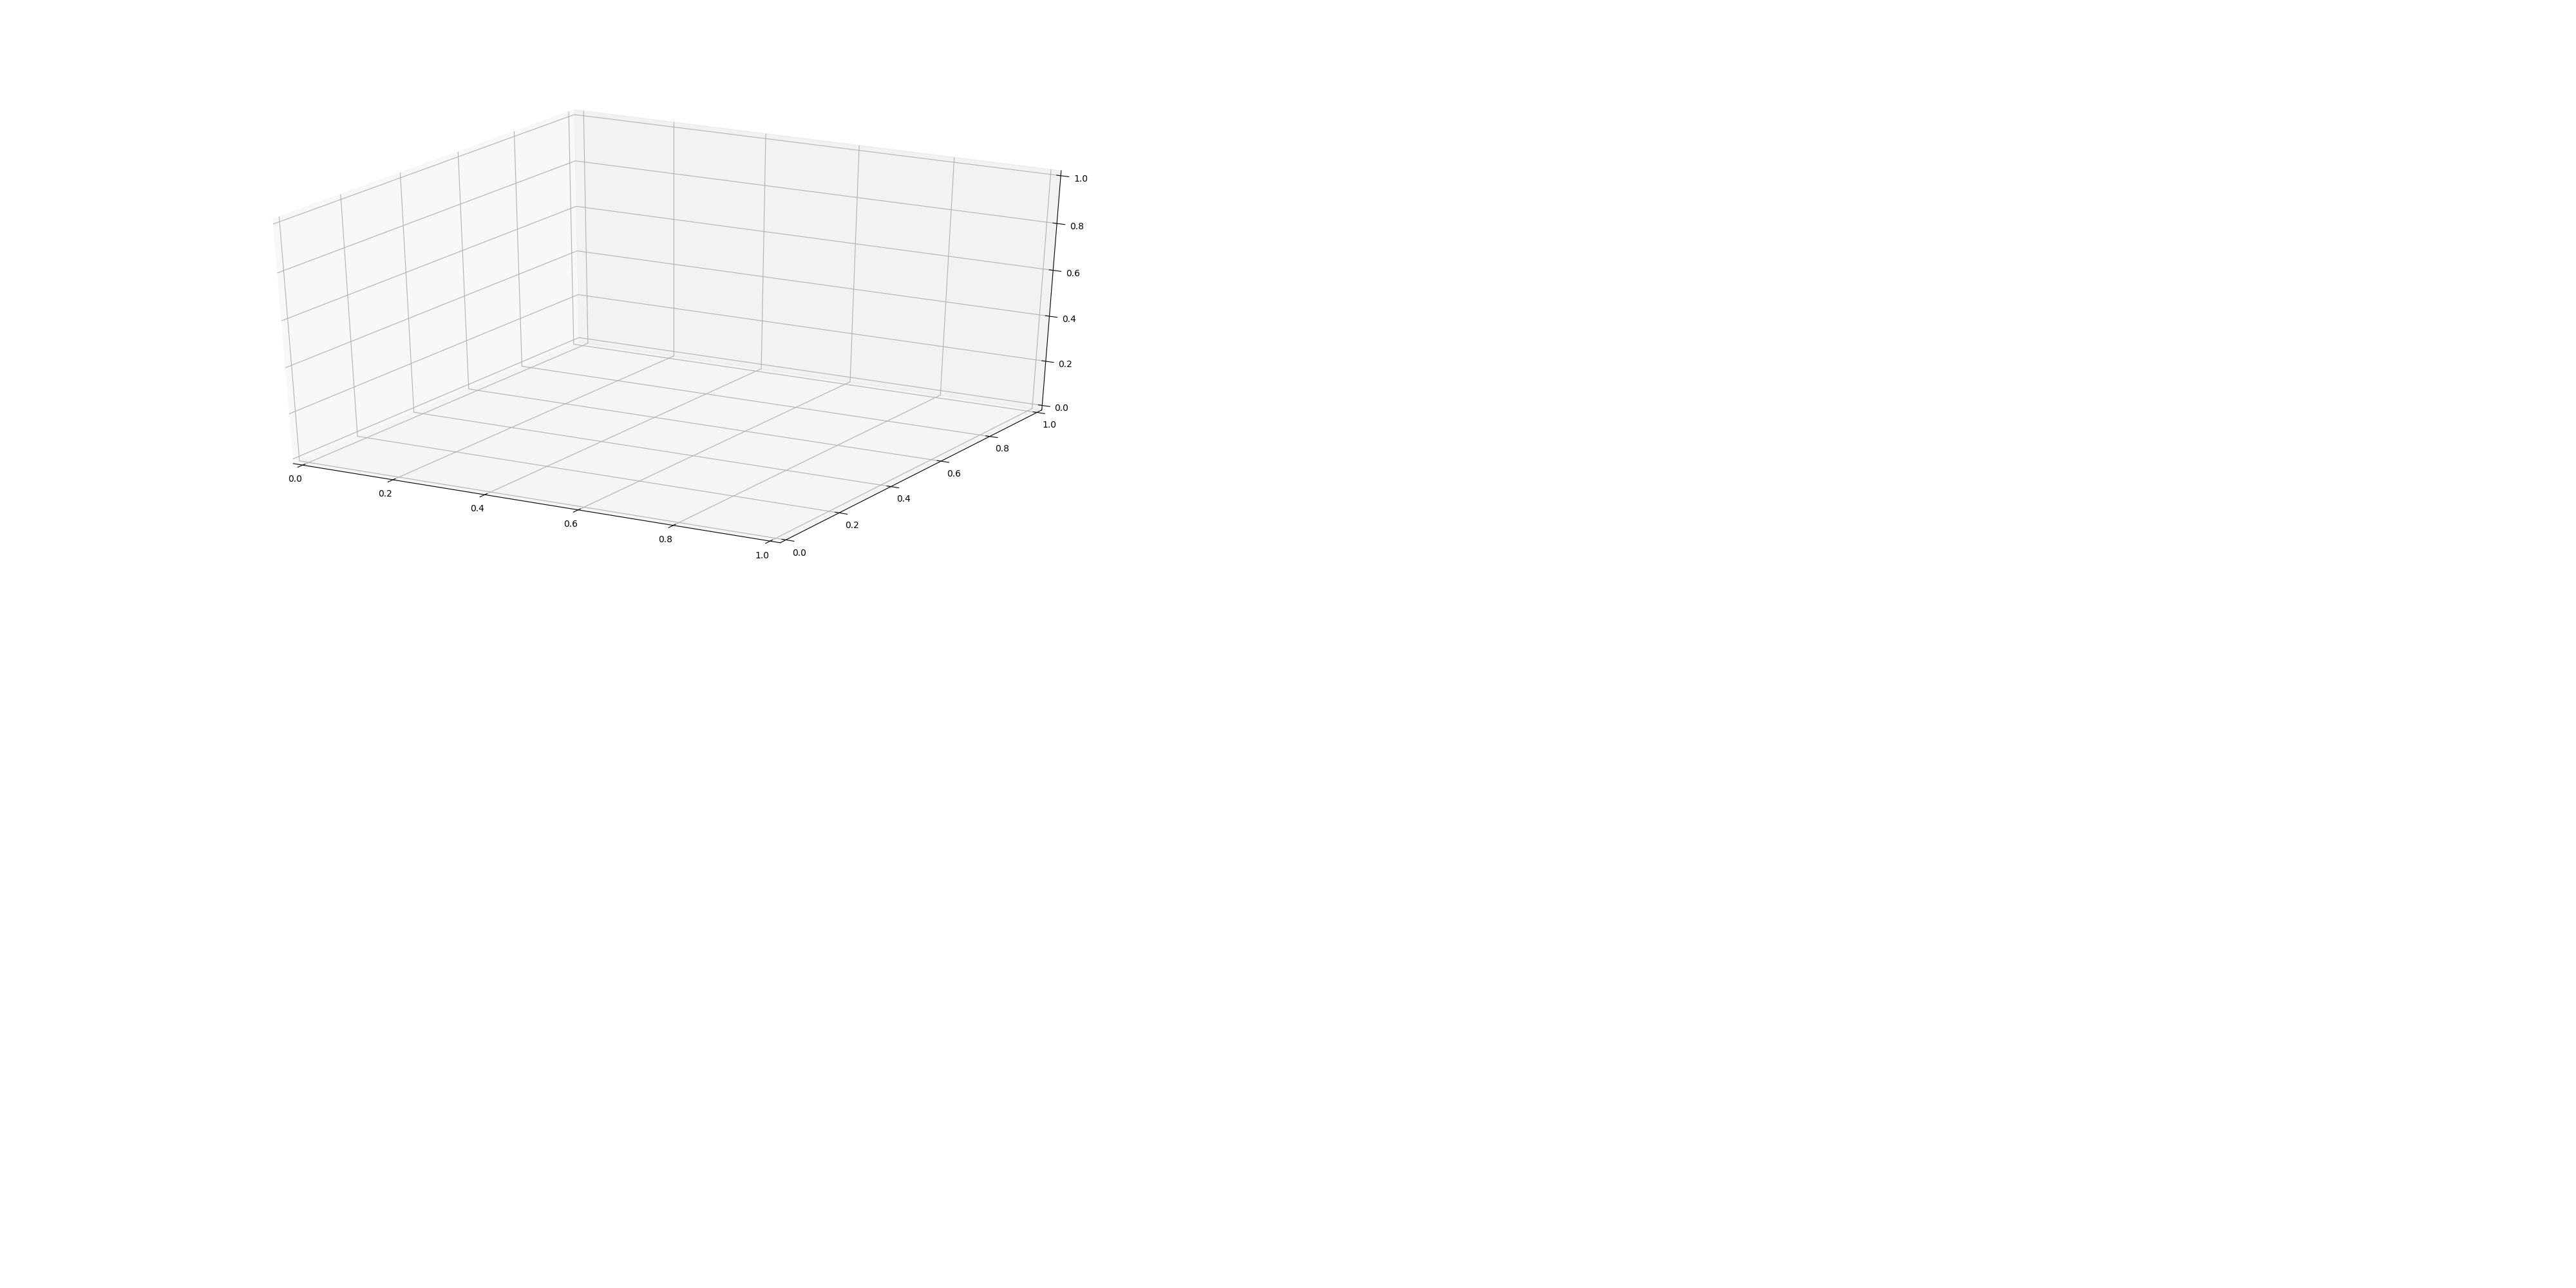

NameError: name 'cur_mesh' is not defined

In [28]:
# plot

fig = plt.figure(figsize=[20,10])
ax=fig.add_subplot(111, projection='3d')

# membrane
ax.plot_surface(cur_mesh.x3d,cur_mesh.y3d, cur_mesh.z3d, color='g', alpha=0.5)

# filaments

for filament in all_filaments_df.index.unique():
    cur_filament = all_filaments_df[all_filaments_df.index==filament]
    colorVal = scalarMap.to_rgba(cur_filament['ydir'])
    ax.plot(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], color=colorVal[0], linewidth=5)
    
# plt.xlim([500,1400])
# plt.ylim([350,950])
# ax.set_zlim([50,250])

# ax.set_xticks(np.arange(500,1400,100))
# ax.set_yticks(np.arange(400,1000,100))
# ax.set_zticks([100,200])


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


# with actin

In [ ]:
# # arrowheads??
# # https://stackoverflow.com/questions/22867620/putting-arrowheads-on-vectors-in-matplotlibs-3d-plot
# import numpy as np
# from numpy import *
# from matplotlib import pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib.patches import FancyArrowPatch
# from mpl_toolkits.mplot3d import proj3d

# class Arrow3D(FancyArrowPatch):
#     def __init__(self, xs, ys, zs, *args, **kwargs):
#         FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
#         self._verts3d = xs, ys, zs

#     def draw(self, renderer):
#         xs3d, ys3d, zs3d = self._verts3d
#         xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
#         self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
#         FancyArrowPatch.draw(self, renderer)


In [29]:
# fig = plt.figure(figsize=(15,15))
# ax = fig.add_subplot(111, projection='3d')

# a = Arrow3D(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], mutation_scale=20, 
#                 lw=3, arrowstyle="-|>", color="r")
# ax.add_artist(a)


## color code each segment